# Compare INMAP and BenMAP mortality output

Author : Yunha Lee 

Date: Mar 26, 2025

INMAP mortality is based on Krewski et al. (2009).
 - using a Cox proportional hazards model and assuming a 6% increase in overall mortality for every 10 μg/m³ increase in PM2.5 concentration 
 - for the adults aged 30 and older  (double check this)

BenMAP mortality is based on Di et al. (2017)
 - causal inference methods (e.g., doubly robust approaches, machine learning techniques) and a log-linear exposure-response function.
 - aged 65 and older
 - The estimated risk is higher than Krewski et al. (2009)
 - adverse effects even at low PM₂.₅ concentrations


**Important note:** The comparisons will be done for total health impact, not by regions because different grid resolutions.  INMAP output is varying grids, while BenMAP output is at county-level (can be coarser than INMAP).

Next step : I plan to include BenMAP with Pope et al (2019), which includes younger population
  
 
 

## Step 1: Read INMAP mortality sums

In [1]:
import pandas as pd
import os

main_dir = '/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/model_analysis/'
run_list = ['LA_CCS', 'LA_CCS_noNH3'] # ['CO_CCS', 'CO_CCS_wo_NH3_VOC', 'CO_Suncor_CCS_wo_NH3_VOC','CO_Cherokee_CCS_wo_NH3_VOC', 'NEI_no_Landfill_2001411']
target_file = 'mortality_sums.csv'

combined_df = None

for run in run_list:
    output_path = os.path.join(main_dir, run)
    df = pd.read_csv(output_path + '/'+target_file, header=None)

    df.columns = ["Race", "INMAP_Krewski: "+run]

    # Merge on 'Species' column
    if combined_df is None:
        combined_df = df  # First dataframe, set as base
    else:
        combined_df = pd.merge(combined_df, df, on="Race", how="outer")

combined_df.dropna(inplace=True)
print(combined_df)

         Race  INMAP_Krewski: LA_CCS  INMAP_Krewski: LA_CCS_noNH3
0      AsianD              -0.881438                    -4.808422
1      BlackD              10.915206                   -54.742148
2     LatinoD             -10.905064                   -27.529759
3     NativeD              -0.422220                    -1.195898
4   TotalPopD             -28.015269                  -217.942078
5  WhitNoLatD             -26.000025                  -125.796758


In [2]:
rename_inmap ={'TotalPopD': 'ALL', 'AsianD': 'ASIAN','BlackD':'BLACK', 'NativeD':"NATAMER", 'LatinoD': "HISPANIC",'WhitNoLatD':'WHITE'}

# change INMAP race value to match BenMAP
combined_df['Race'] = combined_df['Race'].replace(rename_inmap)

# Change the sign of value to match BenMAP
for name in combined_df.columns:
    if name != 'Race': 
        combined_df[name] = combined_df[name] * -1 # convert negative value to positive 

combined_df

,Race,INMAP_Krewski: LA_CCS,INMAP_Krewski: LA_CCS_noNH3
0,ASIAN,0.881438,4.808422
1,BLACK,-10.915206,54.742148
2,HISPANIC,10.905064,27.529759
3,NATAMER,0.422220,1.195898
4,ALL,28.015269,217.942078
5,WHITE,26.000025,125.796758


## Step 2: Read BenMAP mortality sums

In [4]:
benmap_file = '/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/BenMAP/county/incidence_results/Health_Benefit_all_CO_runs.csv'

df_benmap = pd.read_csv(benmap_file)

df_benmap['Endpoint'] = df_benmap['Endpoint'].str.strip()

print(df_benmap['Endpoint'])

# delete the first column and Endpoint, which is just row number
df_benmap = df_benmap.drop(df_benmap.columns[0], axis=1)



def subset_clean_benmap_df(df, author_name):
    # subset mortality using author 
    df = df[df['Endpoint'].str.contains(author_name, na=False)]

    # delete the Endpoint column
    df = df.drop(df.columns[0], axis=1)

    # rename columns to contain benmap
    for name in df.columns:
        if name != 'Race': 
            df.rename(columns={name: f"BenMAP_{author_name}: " + name}, inplace=True)

    return df

df_benmap_Di = subset_clean_benmap_df(df_benmap, 'Di')
df_benmap_Pope = subset_clean_benmap_df(df_benmap, 'Pope')

merged_benmap_df = pd.merge(df_benmap_Di, df_benmap_Pope, on='Race', how='inner')
print(merged_benmap_df)


0                   Asthma Exacerbation  Cough
1                   Asthma Exacerbation  Cough
2     Asthma Exacerbation  Shortness of Breath
3     Asthma Exacerbation  Shortness of Breath
4                  Asthma Exacerbation  Wheeze
5                  Asthma Exacerbation  Wheeze
6             Mortality All Cause by Di et al.
7             Mortality All Cause by Di et al.
8             Mortality All Cause by Di et al.
9             Mortality All Cause by Di et al.
10            Mortality All Cause by Di et al.
11            Mortality All Cause by Di et al.
12          Mortality All Cause by Pope et al.
13          Mortality All Cause by Pope et al.
14          Mortality All Cause by Pope et al.
15          Mortality All Cause by Pope et al.
16          Mortality All Cause by Pope et al.
17          Mortality All Cause by Pope et al.
18                              Work Loss Days
Name: Endpoint, dtype: object
       Race  BenMAP_Di: LA_CCS  BenMAP_Di: LA_CCS_noNH3  BenMAP_Pope: LA_CCS 

{'LA_CCS_noNH3', 'LA_CCS'}
checking subset           INMAP_Krewski: LA_CCS_noNH3  BenMAP_Di: LA_CCS_noNH3  \
Race                                                             
ALL                        217.942078                 127.2000   
WHITE                      125.796758                 100.0000   
BLACK                       54.742148                  74.5600   
ASIAN                        4.808422                   2.0230   
NATAMER                      1.195898                   0.7738   
HISPANIC                    27.529759                  10.5400   

          BenMAP_Pope: LA_CCS_noNH3  
Race                                 
ALL                         260.200  
WHITE                       227.300  
BLACK                        89.670  
ASIAN                         2.910  
NATAMER                       1.322  
HISPANIC                     30.140  


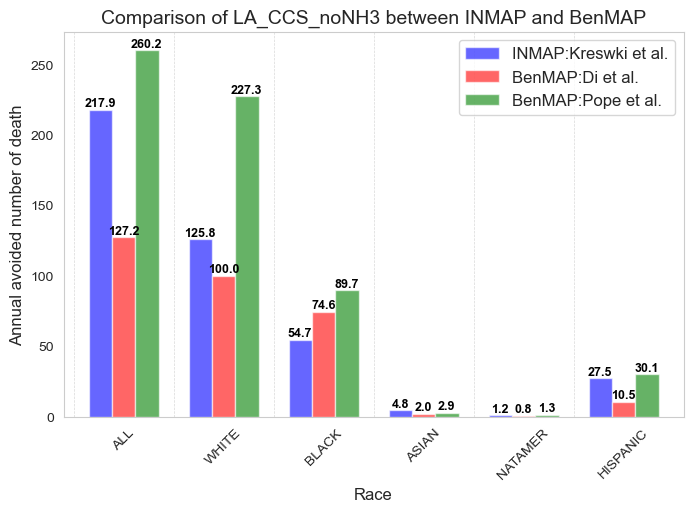

checking subset           INMAP_Krewski: LA_CCS  BenMAP_Di: LA_CCS  BenMAP_Pope: LA_CCS
Race                                                                   
ALL                   28.015269            37.7000              76.4100
WHITE                 26.000025            33.1600              76.5000
BLACK                -10.915206            10.9400              12.1700
ASIAN                  0.881438             0.8213               1.1270
NATAMER                0.422220             0.3271               0.5614
HISPANIC              10.905064             4.9680              14.7400


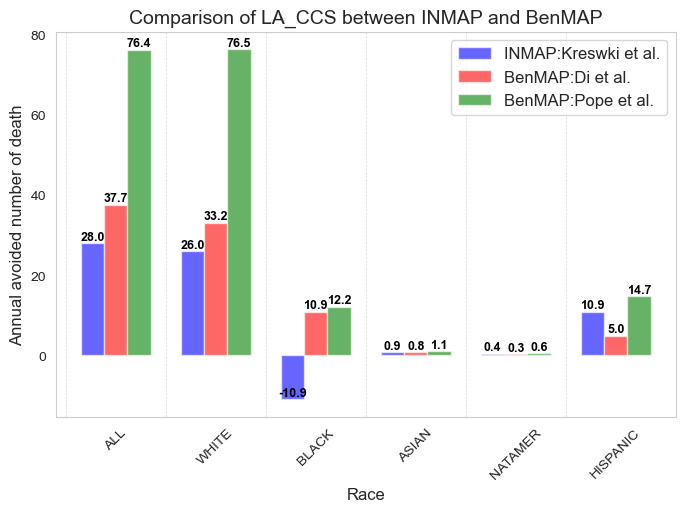

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# combine two dataframe
merged_df = combined_df.merge(merged_benmap_df, on="Race", how="inner")

# Set seaborn style
sns.set_style("whitegrid")

# Convert the column to categorical with the specified order
race_order = ["ALL","WHITE",  "BLACK", "ASIAN", "NATAMER", "HISPANIC"]
merged_df['Race'] = pd.Categorical(merged_df['Race'], categories=race_order, ordered=True)

# Sort the DataFrame by the ordered Race column
merged_df = merged_df.sort_values(by='Race')

# Ensure "Race" is the index
merged_df.set_index("Race", inplace=True)


# Extract unique run names, excluding "Race"
run_names = set(col.split(": ")[1] for col in merged_df.columns if ": " in col)

print(run_names)

# Plot comparison for each run
for run in run_names:
    inmap_col = f"INMAP_Krewski: {run}"
    benmap_col = f"BenMAP_Di: {run}"
    benmap_col2 = f"BenMAP_Pope: {run}"
    
    if inmap_col in merged_df.columns and benmap_col in merged_df.columns:
        # Create a new DataFrame for plotting
        plot_df = merged_df[[inmap_col, benmap_col, benmap_col2]]

        print("checking subset", plot_df)

        # Plot
        ax = plot_df.plot(kind="bar", figsize=(8, 5), width=0.7, color=["Blue", "Red", "Green"], alpha = 0.6)  # Blue & Orange for better contrast
        plt.title(f"Comparison of {run} between INMAP and BenMAP", fontsize=14)
        plt.xlabel("Race", fontsize=12)
        plt.ylabel("Annual avoided number of death", fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(["INMAP:Kreswki et al.", "BenMAP:Di et al.", "BenMAP:Pope et al."], fontsize=12)
        #plt.grid(axis="y", linestyle="--", alpha=0.7)
        ax.grid(False)  # Completely removes the grid
        
        # Add subtle vertical gridlines between categories
        for i in range(len(ax.get_xticks())):
            ax.axvline(x=i - 0.5, color='grey', linestyle='--', linewidth=0.5, alpha=0.3)

        # Add value labels on top of bars
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1f}',  
                        (p.get_x() + p.get_width() / 2., p.get_height()),  
                        ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

        plt.show()
